## Object Localisation Using VGG Net (Pretrained)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
import pickle as pkl
import matplotlib.patches as patches
from scipy import io

In [3]:
from tqdm import tqdm

In [19]:
import time

### About the Dataset

In [4]:
with open('../../../Dataset/VOC2007/data.pkl','rb') as fp:
    data = pkl.load(fp)
with open('../../../Dataset/VOC2007/labels.pkl','rb') as fp:
    labels = pkl.load(fp)    
with open('../../../Dataset/VOC2007/name.pkl','rb') as fp:
    name = pkl.load(fp)

In [5]:
print data.shape
print labels.shape
print len(name)

(5011, 28, 28, 3)
(5011, 4)
5011


In [9]:
class_labels = pd.get_dummies(name)
print class_labels.columns

Index([u'aeroplane', u'bicycle', u'bird', u'boat', u'bottle', u'bus', u'car',
       u'cat', u'chair', u'cow', u'diningtable', u'dog', u'horse',
       u'motorbike', u'person', u'pottedplant', u'sheep', u'sofa', u'train',
       u'tvmonitor'],
      dtype='object')


In [23]:
print class_labels.values.dtype

float64


In [28]:
data = np.asarray(data,dtype=np.float32)
print data.dtype

float32


In [7]:
def plot_boundingBox(image,(x1,y1),w,h):
    x1,y1,w,h = int(x1),int(y1),int(w),int(h)
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((x1,y1),w,h,linewidth=1,facecolor='none',edgecolor='r')
    ax.add_patch(rect)
    plt.show()

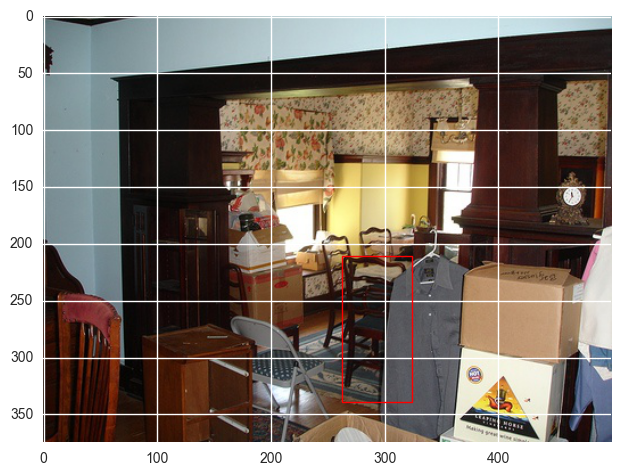

In [8]:
image = plt.imread('../../../Dataset/VOC2007/JPEGImages/000005.jpg')
bndbox = [263,211,324,339]
plot_boundingBox(image,(263,211),324-263,339-211)

### VGG Net

In [8]:
IMAGE_WIDTH = 221
IMAGE_HEIGHT = 221
IMAGE_DEPTH = 3
NUM_CLASSES = 20
BATCH_SIZE = 128

In [9]:
path = '../../Tensorflow-CS20SI/Assignment_2/style_transfer/imagenet-vgg-verydeep-19.mat'

In [10]:
tf.reset_default_graph()
def _weights(vgg_layers,layer,expected_layer_name):
    W = vgg_layers[0][layer][0][0][2][0][0]
    b = vgg_layers[0][layer][0][0][2][0][1]
    layer_name = vgg_layers[0][layer][0][0][0][0]
    assert layer_name == expected_layer_name
    return W, b.reshape(b.size)

def _conv2d_relu(vgg_layers, prev_layer, layer, expected_layer_name):
    with tf.variable_scope(expected_layer_name) as scope:

        W,b = _weights(vgg_layers, layer, expected_layer_name)
        W = tf.constant(W)
        b = tf.constant(b)
        conv = tf.nn.conv2d(prev_layer,W,strides=[1,1,1,1],padding="SAME")
        relu = tf.nn.relu(conv + b,name=scope.name)
        return relu

def _avgpool(prev_layer,layer_name):
    with tf.variable_scope(layer_name) as scope:
        avgpool = tf.nn.avg_pool(prev_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
        return avgpool

def _fully_connected(prev_layer,num_neurones,layer_name):
    with tf.variable_scope(layer_name) as scope:
        shape = prev_layer.get_shape().as_list()
        try:
            flattened = shape[1]*shape[2]*shape[3]
            flat = tf.reshape(prev_layer,[-1,flattened])
        except:
            flattened = shape[1]
            flat = prev_layer
        W = tf.get_variable('weights',shape=[flattened,num_neurones],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('biases',shape=[num_neurones],initializer=tf.random_normal_initializer())
        out = tf.matmul(flat,W)
        relu = tf.nn.relu(out + b, name = scope.name)
        return relu
    
def _softmax(prev_layer, num_output, layer_name):
    with tf.variable_scope(layer_name) as scope:
        try:
            shape = prev_layer.get_shape().as_list()
            flattened = shape[1]*shape[2]*shape[3]
            flat = tf.reshape(prev_layer,[-1,flattened])
        except:
            flattened = prev_layer.get_shape().as_list()[1]
            flat = prev_layer
        W = tf.get_variable(name='weights',shape=[flattened,num_output],
                           initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(name='biases',shape=[num_output],initializer=tf.random_normal_initializer())
        out = tf.nn.softmax(tf.matmul(flat,W) + b)
        return out

In [11]:
vgg = io.loadmat(path)
vgg_layers = vgg['layers']

In [12]:
graph = {}
with tf.variable_scope("placeholders") as scope:
    input_image = tf.placeholder(shape=[None,IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_DEPTH],dtype=tf.float32,name="Input")
    label = tf.placeholder(shape=[None,NUM_CLASSES],dtype=tf.float32,name='Label')
    bndbox = tf.placeholder(shape=[None,1,1,1,1],dtype=tf.float32,name='BoundBox')

## Assembling the graph
print 'Assembling the graph...'
graph = {} 
graph['conv1_1']  = _conv2d_relu(vgg_layers, input_image, 0, 'conv1_1')
graph['conv1_2']  = _conv2d_relu(vgg_layers, graph['conv1_1'], 2, 'conv1_2')
graph['avgpool1'] = _avgpool(graph['conv1_2'],'avgpool1')
graph['conv2_1']  = _conv2d_relu(vgg_layers, graph['avgpool1'], 5, 'conv2_1')
graph['conv2_2']  = _conv2d_relu(vgg_layers, graph['conv2_1'], 7, 'conv2_2')
graph['avgpool2'] = _avgpool(graph['conv2_2'],'avgpool2')
graph['conv3_1']  = _conv2d_relu(vgg_layers, graph['avgpool2'], 10, 'conv3_1')
graph['conv3_2']  = _conv2d_relu(vgg_layers, graph['conv3_1'], 12, 'conv3_2')
graph['conv3_3']  = _conv2d_relu(vgg_layers, graph['conv3_2'], 14, 'conv3_3')
graph['conv3_4']  = _conv2d_relu(vgg_layers, graph['conv3_3'], 16, 'conv3_4')
graph['avgpool3'] = _avgpool(graph['conv3_4'],'avgpool3')
graph['conv4_1']  = _conv2d_relu(vgg_layers, graph['avgpool3'], 19, 'conv4_1')
graph['conv4_2']  = _conv2d_relu(vgg_layers, graph['conv4_1'], 21, 'conv4_2')
graph['conv4_3']  = _conv2d_relu(vgg_layers, graph['conv4_2'], 23, 'conv4_3')
graph['conv4_4']  = _conv2d_relu(vgg_layers, graph['conv4_3'], 25, 'conv4_4')
graph['avgpool4'] = _avgpool(graph['conv4_4'],'avgpool4')
graph['conv5_1']  = _conv2d_relu(vgg_layers, graph['avgpool4'], 28, 'conv5_1')
graph['conv5_2']  = _conv2d_relu(vgg_layers, graph['conv5_1'], 30, 'conv5_2')
graph['conv5_3']  = _conv2d_relu(vgg_layers, graph['conv5_2'], 32, 'conv5_3')
graph['conv5_4']  = _conv2d_relu(vgg_layers, graph['conv5_3'], 34, 'conv5_4')
graph['avgpool5'] = _avgpool(graph['conv5_4'],'avgpool5')
graph['fc6'] = _fully_connected(graph['avgpool5'],128,'fc6')
graph['softmax'] = _softmax(graph['fc6'],20,'softmax')
graph['regressor_fc6'] = _fully_connected(graph['avgpool5'],128,'regressor_fc6')
graph['boundBox'] = _fully_connected(graph['regressor_fc6'],4,'boundBox')

Assembling the graph...


## Defining Loss and Optimizer

In [13]:
def _xentropyloss(correct_output, softmax_output, loss_name):
    with tf.variable_scope(loss_name) as scope:
        loss = tf.reduce_mean(-tf.reduce_sum(correct_output*tf.log(softmax_output),reduction_indices=[1]))
        return loss

In [14]:
def _regressionloss(correct_box, regressor_output, loss_name):
    with tf.variable_scope(loss_name) as scope:
        loss = tf.reduce_mean(tf.reduce_sum(tf.squared_difference(correct_box,regressor_output),reduction_indices=[1]))
    return loss

In [15]:
def optimizer(loss,learning_rate):
    with tf.variable_scope("optimizer") as scope:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        return optimizer

In [16]:
graph['classification_loss'] = _xentropyloss(label, graph['softmax'], 'classification_loss')
graph['regression_loss'] = _regressionloss(bndbox, graph['boundBox'], 'regression_loss')
graph['classification_optimizer'] = optimizer(graph['classification_loss'],1e-3)
graph['regression_optimizer'] = optimizer(graph['regression_loss'],1e-3)

In [18]:
n_epochs = 1
n_batches = data.shape[0]/BATCH_SIZE

39


In [ ]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    writer = tf.summary.FileWriter('graphs/', sess.graph)
    print 'Training for Classification Head'
    for i in range(n_epochs):
        epoch_loss = 0
        
        for j in range(n_batches):
            
            cur_batch, next_batch = j*BATCH_SIZE, (j+1)*BATCH_SIZE
            x_batch = data[cur_batch:next_batch,:,:,:]
            y_batch = class_labels[cur_batch:next_batch,:]
            print x_batch.shape,y_batch.shape
            start_time = time.time()
            _, l = sess.run([graph['classification_optimizer'],graph['classification_loss']],
                           feed_dict = {input_image:x_batch, label:y_batch})
            epoch_loss += l
            end_time = time.time()
            print 'Time taken by a batch: {}'.format(end_time - start_time)
            
        print 'Epoch: {}\t Loss:{}'.format(i+1,l)

Training for Classification Head
(128, 221, 221, 3) (128, 20)
